In [1]:
import os
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
os.chdir('Documents/repos/regression')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 '.ipynb_checkpoints',
 'img',
 'kaggle_salary_prediction.ipynb',
 'my_functions.py',
 'new_stock_prediction.ipynb',
 'part-00000-ae5017c8-fabc-4520-8422-5d3e4bf0caea-c000.csv',
 'part-00000-dca064db-f907-4493-9058-c46de55927a8-c000.csv',
 'README.md',
 'regression.ipynb',
 'stock_prediction.ipynb',
 '__pycache__']

In [3]:
# set time interval (displayed for example, full time interval requested with these parameters)
start = datetime.datetime(1800, 1, 1)
end = datetime.date.today()
 
# Quandl API key from your personal account
api_key = '7__Wy8c2tpqaSnHRyQfp'
    
s = "AAPL"
stock = quandl.get("WIKI/" + s, api_key=api_key)
stock.index = pd.to_datetime(stock.index, format = '%Y-%m-%d')
print("{0} stock data from {1} to {2} downloaded form Quandl."
      .format(s, start, end))

AAPL stock data from 1800-01-01 00:00:00 to 2019-06-05 downloaded form Quandl.


Text(0.5, 0.98, 'Adj. Close of AAPL from 1800-01-01 00:00:00 to 2019-06-05')

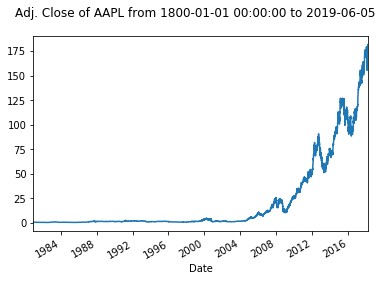

In [4]:
column = 'Adj. Close'
stock[column].plot()
plt.suptitle("{0} of {1} from {2} to {3}"
             .format(column, s, start, end))

### Time series data

A time series is a sequence of vectors (or scalars) which depend on time $t$.

$ \{~x(t_0), x(t_1),~\dots,~x(t_{i-1}), x(t_i), x(t_{i+1}),~\dots~\} $

which is an output from some process $P$ in which we are interested.

$ \boxed { P } \longrightarrow x(t) $

A time-series is a **collection of observations or measurements taken over a period of time**, generally in equal intervals. Time-series only contain numeric data types and are **indexed by time**. In other words, time-series data is always sortable by time.

Phenomena described by time series can be 


* **discrete** (stock closing value each day, number of sales per day) 


* **continuous** (continuous signal)

    * $t$ is real-valued, and $x(t)$ is a continuous signal
    
    * **continuous** phenomena can be turned into **discrete** via **sampling or resampling**
    
    * in uniform sampling, if the sampling period is chosen as $\delta t$, then
    
    $ \{ x(t) \} = \{ ~ x(0), x(\Delta t), x(2 \Delta t), x(3 \Delta t), ~ \dots ~ \} $
    
In addition to describing either discrete or continuous phenomena, time series can also be **deterministic** vs **stochastic**, governed by **linear** vs **nonlinear** dynamics, _etc._

### Possible types of processing time series

Possible types of processing tasks for time series include:
* **predict** future values of $x[t]$
* **classify** a series into one of a few classes:
    * "price will go up"
    * "price will go down -- sell now"
    * "no change"
* **describe** a series using a few parameter values of some model
* **transform** one time series into another
    * oil prices $\mapsto$ interest rates

### Resampling

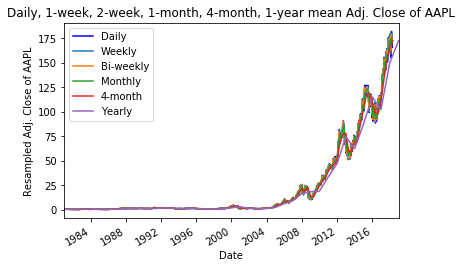

In [14]:
stock_1w_avg = stock.resample('5D').mean()
stock_2w_avg = stock.resample('10D').mean()
stock_1m_avg = stock.resample("M").mean()
stock_4m_avg = stock.resample("4M").mean()
stock_1y_avg = stock.resample("Y").mean()

f, ax = plt.subplots(1)
stock[column].plot(ax=ax, color='blue', label='Daily')
stock_1w_avg[column].plot(ax=ax, label='Weekly')
stock_2w_avg[column].plot(ax=ax, label='Bi-weekly')
stock_1m_avg[column].plot(ax=ax, label='Monthly')
stock_4m_avg[column].plot(ax=ax, label='4-month')
stock_1y_avg[column].plot(ax=ax, label='Yearly')
ax.set_title("Daily, 1-week, 2-week, 1-month, 4-month, 1-year mean {0} of {1}"
             .format(column, s))
ax.set_ylabel("{0} of {1}".format(column, s))
ax.legend(loc='upper left')
ax.set_ylabel("Resampled " + column + " of " + s)
plt.show()

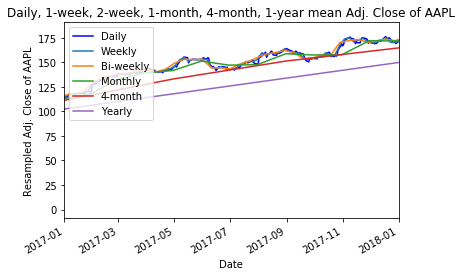

In [13]:
f, ax = plt.subplots(1)
stock[column].plot(ax=ax, color='blue', label='Daily')
stock_1w_avg[column].plot(ax=ax, label='Weekly')
stock_2w_avg[column].plot(ax=ax, label='Bi-weekly')
stock_1m_avg[column].plot(ax=ax, label='Monthly')
stock_4m_avg[column].plot(ax=ax, label='4-month')
stock_1y_avg[column].plot(ax=ax, label='Yearly')
ax.set_title("Daily, 1-week, 2-week, 1-month, 4-month, 1-year mean {0} of {1}"
             .format(column, s))
ax.set_xlim('2017', '2018')
ax.legend(loc='upper left')
ax.set_ylabel("Resampled " + column + " of " + s)
plt.show()

### Input feature - Adj. Close

In [16]:
stock_ts = stock[[column]]
stock_ts_se = stock_ts[column].reset_index(drop=True)
stock_1w_ts_se = stock_1w_avg[column].reset_index(drop=True)
stock_2w_ts_se = stock_2w_avg[column].reset_index(drop=True)
stock_1m_ts_se = stock_1m_avg[column].reset_index(drop=True)
stock_4m_ts_se = stock_4m_avg[column].reset_index(drop=True)
stock_1y_ts_se = stock_1y_avg[column].reset_index(drop=True)
print("DataFrame with daily data and Series with daily and resampled data created!")

DataFrame with daily data and Series with daily and resampled data created!


## Embedding of time series

Temporal data presents a challenge to deal with because time is constantly moving forward, next obervation often depends on the values of observations prior to it. However, this also offers us a way to _transform_ a **one-dimensional time vector** into **infinite-dinemsional spatial vector**.

We can accomplish such transformation by setting up a shift register of delays, so we can retain successive values of out time series. Then we can treat each past value as an additional spatial dimension in the input space to our predictor.

This **implicit transformation** of a **one-dimensional time vector** into an **infinite-dimensional spatial vector** is called **_embedding_**.

The input space to our **predictor must be finite**. At each instant $t$, we **truncate the history** to **only the previous $d$ samples**, where $\large{d}$ is called the **embedding dimension**.

<img src='img/pic_1.png' width='500'>

In [17]:
# add columns with lagged values to DataFrame with stock data
stock_ts = pd.concat([stock_ts,
                      stock_ts[column].shift(1),
                      stock_ts[column].shift(2),
                      stock_ts[column].shift(3),
                      stock_ts[column].shift(4),
                      stock_ts[column].shift(5),
                      stock_ts[column].shift(6),
                      stock_ts[column].shift(7),
                      stock_ts[column].shift(8),
                      stock_ts[column].shift(9),
                      stock_ts[column].shift(10),
                      stock_ts[column].shift(11),
                      stock_ts[column].shift(12),
                      stock_ts[column].shift(13),
                      stock_ts[column].shift(14),
                      stock_ts[column].shift(15),
                      stock_ts[column].shift(16),
                      stock_ts[column].shift(17),
                      stock_ts[column].shift(18),
                      stock_ts[column].shift(19),
                      stock_ts[column].shift(20),
                      stock_ts[column].shift(21),
                      stock_ts[column].shift(22),
                      stock_ts[column].shift(23),
                      stock_ts[column].shift(24),
                      stock_ts[column].shift(25),
                      stock_ts[column].shift(26),
                      stock_ts[column].shift(27),
                      stock_ts[column].shift(28),
                      stock_ts[column].shift(29),
                      stock_ts[column].shift(30),
                      stock_ts[column].shift(31),
                      stock_ts[column].shift(32),
                      stock_ts[column].shift(33),
                      stock_ts[column].shift(34),
                      stock_ts[column].shift(35),
                      stock_ts[column].shift(-1),
                      stock_ts[column].shift(-5),
                      stock_ts[column].shift(-10),
                      stock_ts[column].shift(-20),
                      stock_ts[column].shift(-80),
                      stock_ts[column].shift(-240)], axis=1)
columns = [column, "t-1", "t-2", "t-3", "t-4", "t-5", 
           "t-6", "t-7", "t-8", "t-9", "t-10", "t-11",
           "t-12", "t-13", "t-14", "t-15", "t-16", 
           "t-17", "t-18", "t-19", "t-20", "t-21", 
           "t-22", "t-23", "t-24", "t-25", "t-26", 
           "t-27", "t-28", "t-29", "t-30", "t-31",
           "t-32", "t-33", "t-34", "t-35",
           "t+1", "t+5", "t+10",
           "t+20", "t+80", "t+240"]
stock_ts.columns = columns
stock_ts = stock_ts.iloc[35:]
stock_ts.head()

,Adj. Close,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,...,t-32,t-33,t-34,t-35,t+1,t+5,t+10,t+20,t+80,t+240
Date,,,,,,,,,,,,,,,,,,,,,
1981-02-03,0.406092,0.391536,0.415355,0.439173,0.455787,0.470490,0.474166,0.481517,0.483282,0.477841,...,0.380362,0.371246,0.400652,0.422706,0.420795,0.400652,0.400652,0.382273,0.487104,0.299643
1981-02-04,0.420795,0.406092,0.391536,0.415355,0.439173,0.455787,0.470490,0.474166,0.481517,0.483282,...,0.391536,0.380362,0.371246,0.400652,0.420795,0.387713,0.376833,0.380362,0.487104,0.292145
1981-02-05,0.420795,0.420795,0.406092,0.391536,0.415355,0.439173,0.455787,0.470490,0.474166,0.481517,...,0.415355,0.391536,0.380362,0.371246,0.422706,0.384185,0.356543,0.376833,0.463139,0.297732
1981-02-06,0.422706,0.420795,0.420795,0.406092,0.391536,0.415355,0.439173,0.455787,0.470490,0.474166,...,0.435644,0.415355,0.391536,0.380362,0.400652,0.374922,0.361983,0.347428,0.463139,0.303172
1981-02-09,0.400652,0.422706,0.420795,0.420795,0.406092,0.391536,0.415355,0.439173,0.455787,0.470490,...,0.454023,0.435644,0.415355,0.391536,0.400652,0.384185,0.349192,0.330813,0.472254,0.305083


## Autocorrelation

From [machinelearningmastery.com](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/):

An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step.

This relationship between variables is called _correlation_.

If both variables change in the same direction (e.g. go up together or down together), this is called a _positive correlation_. If the variables move in opposite directions as values change (e.g. one goes up and one goes down), then this is called _negative correlation_.

We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

Again, because the correlation is calculated between the variable and itself at previous time steps, it is called an _autocorrelation_. It is also called _serial correlation_ because of the sequenced structure of time series data.

The correlation statistics can also help to choose which lag variables will be useful in a model and which will not.

Interestingly, if all lag variables show low or no correlation with the output variable, then it suggests that the time series problem may not be predictable. This can be very useful when getting started on a new dataset.

### Quick check for autocorrelation
We can plot the observation at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot.

In [ ]:
# list of original and resampled time series
ts_list = [stock_ts_se, stock_1w_ts_se, stock_2w_ts_se,
           stock_1m_ts_se, stock_4m_ts_se, stock_1y_ts_se]
# list of time series titles
ts_title_list = ["daily {0} of {1}".format(column, s),
                 "weekly resampled {0} of {1}".format(column, s),
                 "bi-weekly resampled {0} of {1}".format(column, s),
                 "monthly resampled {0} of {1}".format(column, s),
                 "4-month resampled {0} of {1}".format(column, s),
                 "annual resampled {0} of {1}".format(column, s)]

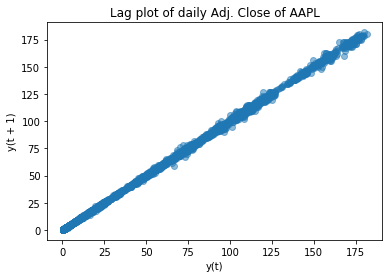

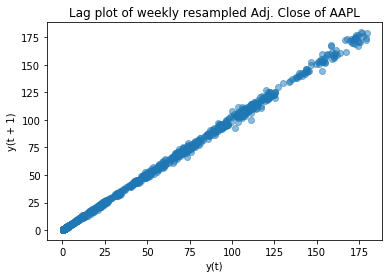

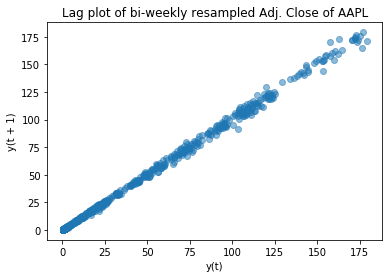

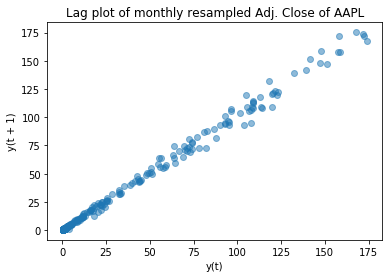

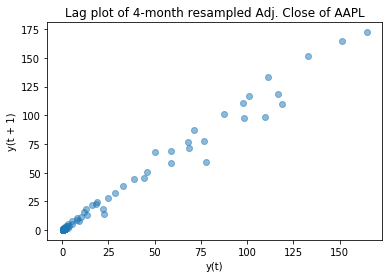

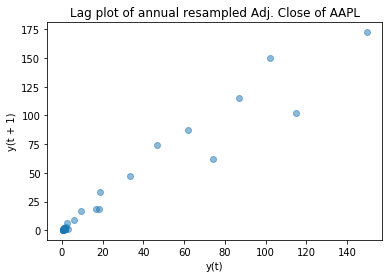

In [41]:
i = 0
for series in ts_list:
    pd.plotting.lag_plot(series, alpha=0.5)
    plt.title("Lag plot of " + ts_title_list[i])
    plt.show()
    i += 1

### Lag plots produced from daily (non-resampled) data with different lags for target (1d, 1w, 2w, 1m, 4m, 1y)

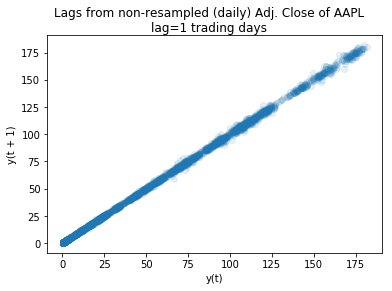

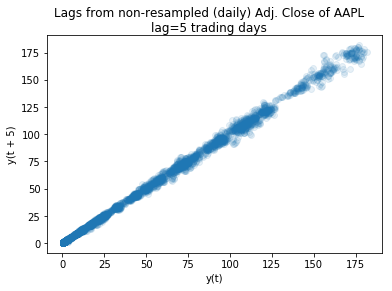

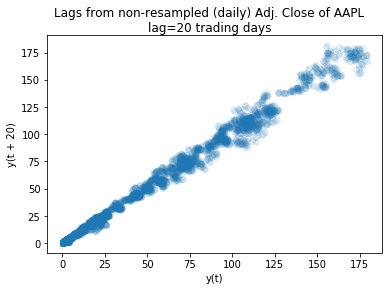

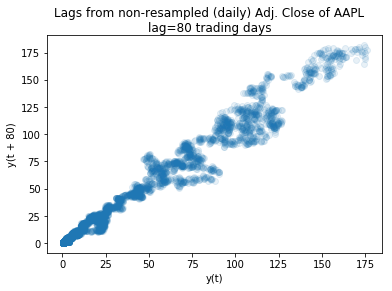

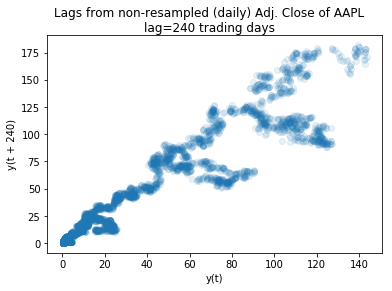

In [73]:
lags = [1, 5, 20, 80, 240]
for lag in lags:
    pd.plotting.lag_plot(stock_ts_se, lag=lag, alpha=0.1)
    plt.suptitle("Lags from non-resampled (daily) {0} of {1}\nlag={2} trading days"
                 .format(column, s, lag))
    plt.show()

### Pearson correlation coefficient
Another quick check that we can do is to directly calculate the correlation between the observation and the lag variable.

We can use a statistical test like the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient). This produces a number to summarize how correlated two variables are between -1 (negatively correlated) and +1 (positively correlated) with small values close to zero indicating low correlation and high values above 0.5 or below -0.5 showing high correlation.

Text(0, 0.5, 'Pearson correlation coefficient')

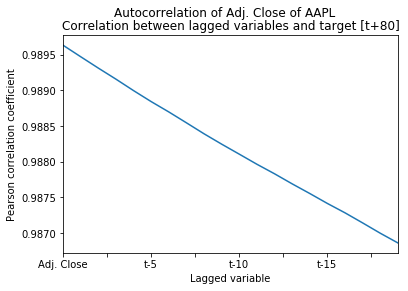

In [31]:
lag = 80
stock_ts.corr().loc['t+' + str(lag)][:20].plot()
plt.suptitle("Autocorrelation of {0} of {1}".format(column, s))
plt.title("Correlation between lagged variables and target "
          "[t+{0}]".format(lag))
plt.xlabel("Lagged variable")
plt.ylabel("Pearson correlation coefficient")

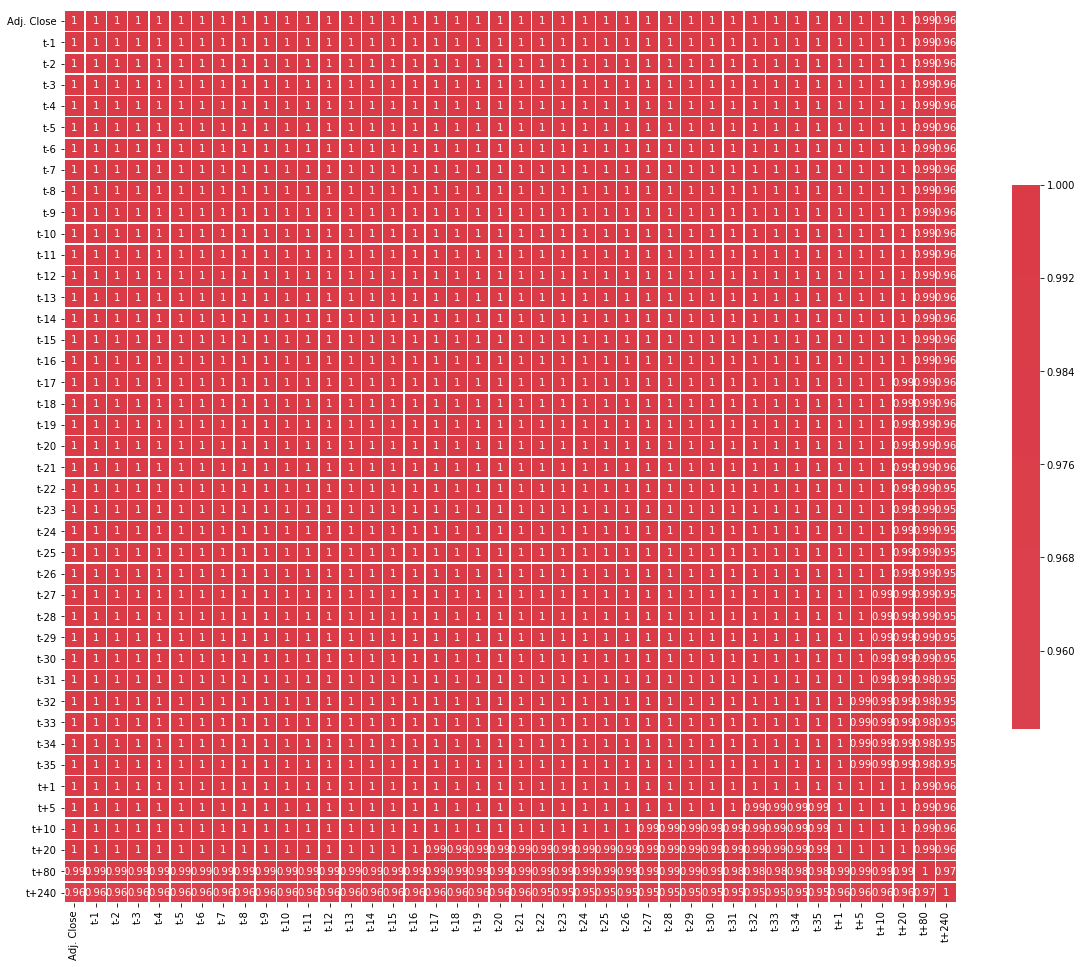

In [32]:
fig, ax = plt.subplots(figsize=(20, 20))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(50, 10, as_cmap=True)
# Draw the heat map with the mask and correct aspect ratio
sns.heatmap(stock_ts.corr(),
            cmap=cmap,
            vmax=1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True,
            ax=ax)
plt.show()

We can plot the correlation coefficient for each lag variable. This can very quickly give an idea of which lag variables may be good candidates for use in a predictive model and how the relationship between the observation and its historic values changes over time.

The plot provides the lag number along the x-axis and the correlation coefficient value between -1 and 1 on the y-axis. The plot also includes solid and dashed lines that indicate the 95% and 99% confidence interval for the correlation values. Correlation values above these lines are more significant than those below the line, providing a threshold or cutoff for selecting more relevant lag values.

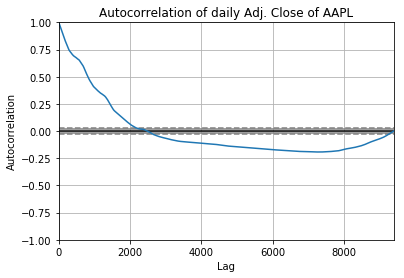

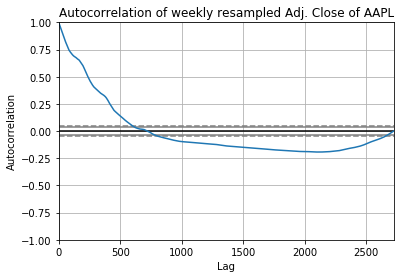

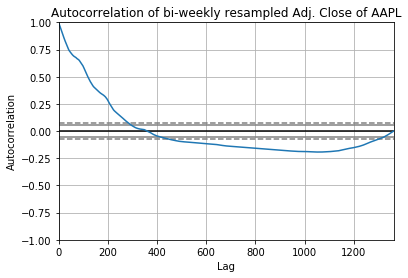

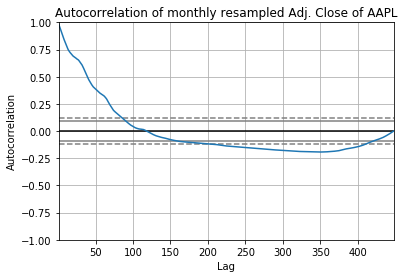

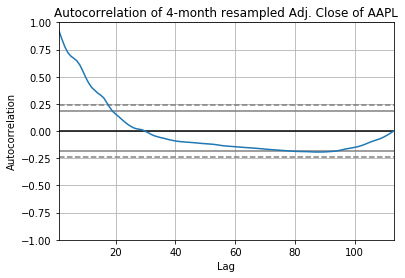

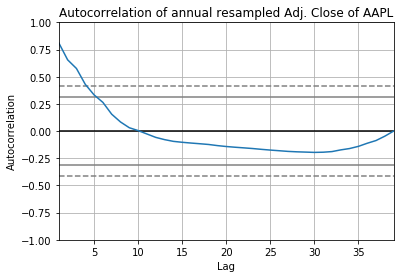

In [38]:
i = 0
for series in ts_list:
    pd.plotting.autocorrelation_plot(series)
    plt.title("Autocorrelation of " + ts_title_list[i])
    plt.show()
    i += 1

Number of lags varies between original daily and resampled data, thus the difference in the number of lags with high correlation coefficient.

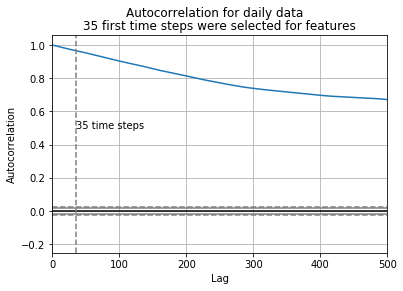

In [50]:
num_steps = 35
f, ax = plt.subplots(1)
pd.plotting.autocorrelation_plot(stock_ts_se, ax=ax)
plt.suptitle("Autocorrelation for daily data")
plt.title("{0} first time steps were selected for features"
          .format(num_steps))
ax.axvline(num_steps, linestyle='--', color='gray')
ax.text(num_steps, 0.5, "{0} time steps".format(num_steps))
ax.set_xlim(0, 500)
plt.show()

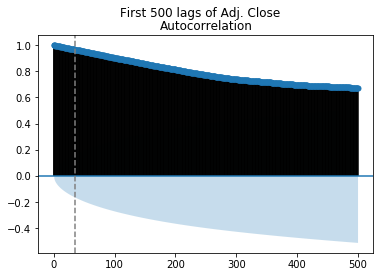

In [54]:
plot_acf(stock_ts_se, lags=500)
plt.suptitle("First 500 lags of {0}".format(column))
plt.axvline(num_steps, linestyle='--', color='gray')
plt.show()

## Time series forecasting models

### Predicting the future

Extending backward from time $t$, we have time series $ \{ ~ x[t], ~ x[t− 1], ~ \dots ~ \} $ . 

From this, we now want to estimate $x$ at some future time

$ \hat{x}[t + s] ~ = ~ f( x[t], ~ x[t-1] ~, ~ \dots ~ ) $

where $\large{s}$ is called the **horizon of prediction**.

If we choose horizon of prediction $s$ to be 1 sample into the future, $\implies s=1$

This is a **function approximation problem**. To solve it, we will adhere to the following **methodology**:


1. **Split** the available historical time series **data into _training_ and _test_ subsets**. 
    * this **can be accomplished by selecting a point in time**
    
    * all the data **prior to the split** point will be used for **_training_** of the model
    
    * all the data **following the split** point will be used to _**test**_ it


2. **Assume a generative model**


3. For every point $x[t_i]$ in the training set, **train the generative model** 
    * a _sliding_ or _expanding gate_ moves through all the data in the **_training_** subset via a loop (or a vectorized implementation via matrix multiplication).
    * **each position** of the gate (iteration of the loop, or row of the table of lagged variables) represents a **moment in the past $t_i$** captured in the training subset  
    * values of the time series that **preceded $t_i$** are used as the **vector of inputs $X$**, 
        * **shape and length of $X$ is determined by the type of the gate** (_expanding_ or _sliding_) **and its length** 
    * **sample at $t_i + 1$** (in the case of horizon of prediction $s=1$) is **used as the target variable $y$**
    * model is **trained by continuously moving the gate over all of the training data**


4. **Test model performance** by using it to **make predictions over the test set** (the part of the available historical time series data that **has not been used in the training** of the model)
    * using the same mechanic as was used for training, the _gate_ moves through the **_test_** subset and 
    * **vectors of inputs $X$ are fed** into the trained model to **make predictions about the next value of $y$** (next value of time series after the _gate_)
    * model predictions are **compared to the real values** of the time series in the **_test_** subset, prediction **error is calculated**

## Train-test split using backtesting

Based on [https://machinelearningmastery.com](https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/):

When evaluating a model for time series forecasting, **we are interested in the performance of the model on data that was not used to train it**. In machine learning, we call this unseen or out of sample data. In applied machine learning, **we often split our data into a train and a test set**: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross validation that.

The fast and powerful methods in machine learning, such as using **train-test splits and k-fold cross validation** (repeats the process by systematically splitting the data into k groups, each given a chance to be a held out model), **do not work in the case of time series** data because they **ignore the temporal components** inherent in the problem.

This is because they **assume that there is no relationship between the observations**, that each observation is independent. This is **not true of time series data**, where the time dimension of observations means that we cannot randomly split them into groups. Instead, **we must split data up and respect the temporal order** in which values were observed.

In time series forecasting, this **evaluation of models on historical data** is called [**backtesting**](https://www.investopedia.com/terms/b/backtesting.asp). In some time series domains, such as meteorology, this is called **hindcasting**, as opposed to forecasting. Backtesting allows a trader to simulate a trading strategy using historical data to generate results and analyze risk and profitability before risking any actual capital. Good correlation between backtesting, out-of-sample and forward performance testing results (paper trading, following system's logic in a live market) is vital for determining the viability of a trading system.

### Backtesting methods

Backtesting can be performed in several ways:

* **Train-Test split** that **respects temporal order of observations**
* **Multiple Train-Test splits** that respect temporal order of observations
* **Walk-Forward Validation** where a model may be updated each time step new data is received

Observations: 9365

Train_test split ratio: 80.00%

Training Observations: 7492
Testing Observations: 1873


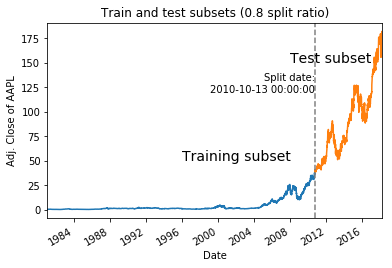

In [72]:
# set train subset ratio
train_subset_ratio = 8 / 10
train_size = int(len(stock_ts) * train_subset_ratio)
# split the data set into train and test
train, test = \
    stock_ts.iloc[0:train_size], \
    stock_ts.iloc[train_size:len(stock_ts)]
print('Observations: %d' % (len(stock_ts)))
print("\nTrain_test split ratio: {0:.2f}%".format(train_subset_ratio * 100))
print('\nTraining Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))
# plot train and test subsets
f, ax = plt.subplots(1)
train[column].plot(ax=ax)
test[column].plot(ax=ax)
plt.title("Train and test subsets ({0} split ratio)"
          .format(train_subset_ratio))
ax.axvline(train.index[-1], linestyle='--', color='gray')
ax.text('1996', 50, "Training subset", fontsize=14)
ax.text('2008', 150, "Test subset", fontsize=14)
ax.text(train.index[-1], 120,
        "Split date:\n{0}".format(train.index[-1]),
        ha='right')
ax.set_ylabel("{0} of {1}".format(column, s))
plt.show()

### Feature selection
Stock data has been modified into a univariate time series at a daily level (trading days only, no weekends - 5 day week).

Features selected for each observation:
* input: previous 35 time steps of daily data (7 weeks)
* targets: values of time series at different horizons of prediction in the future 
    * 1 time step - 1 day
    * 5 time steps - 1 week
    * 10 time steps - 2 weeks
    * 20 time steps - 1 month
    * 80 time steps - 4 months
    * 240 time steps - 1 year

In [75]:
# select input features
X_train = train.loc[:, 'Adj. Close':'t-35']
X_test = test.loc[:, 'Adj. Close':'t-35']

## Assessing model performance
### Root of Mean squared error (RMSE or RMSD)
The root-mean-square deviation (RMSD) or [root-mean-square error (RMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (or sometimes root-mean-squared error) is a frequently used measure of the differences between values (sample or population values) predicted by a model or an estimator and the values observed. The RMSD represents the square root of the second sample moment of the differences between predicted values and observed values or the quadratic mean of these differences. 

These deviations are called residuals when the calculations are performed over the data sample that was used for estimation and are called errors (or prediction errors) when computed out-of-sample. The RMSD serves to aggregate the magnitudes of the errors in predictions for various times into a single measure of predictive power. RMSD is a measure of accuracy, to compare forecasting errors of different models for a particular dataset and not between datasets, as it is scale-dependent.

RMSD is always non-negative, and a value of 0 (almost never achieved in practice) would indicate a perfect fit to the data. In general, a lower RMSD is better than a higher one. However, **comparisons across different types of data would be invalid** because the **measure is dependent on the scale of the numbers** used.

RMSD is the square root of the average of squared errors. The effect of each error on RMSD is proportional to the size of the squared error; thus larger errors have a disproportionately large effect on RMSD. Consequently, RMSD is sensitive to outliers.

$ \large{ RMSE = \sqrt{ \frac{1} {n} \sum\limits_{j=1}^n (y_i - \hat{y}_i)^2 } } $

In [80]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Symmetric mean absolute percentage error (sMAPE)

[Symmetric mean absolute percentage error (SMAPE or sMAPE)](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) is an accuracy measure based on percentage (or relative) errors. The absolute difference between $y_j$ and $\hat{y}_j$ is divided by half the sum of absolute values of the actual value $y_j$ and the forecast value $\hat{y}_j$. The value of this calculation is summed for every fitted point t and divided again by the number of fitted points n.

$ \large{ sMAPE= \frac{100\%} {n} \sum \limits_{j=1}^{n} \frac{|\hat{y}_j - y_j|} {(|y_j| + |\hat{y}_j|) / 2} } $

In contrast to the [mean absolute percentage error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), SMAPE has both a lower bound and an upper bound. Indeed, the formula above provides a result between 0% and 200%. However a percentage error between 0% and 100% is much easier to interpret. That is the reason why the formula below is often used in practice (i.e. no factor 0.5 in denominator):

$ \large{ sMAPE= \frac{100\%} {n} \sum \limits_{j=1}^{n} \frac{|\hat{y}_j - y_j|} {|y_j| + |\hat{y}_j|} } $

One supposed problem with SMAPE is that it is not symmetric since over- and under-forecasts are not treated equally. This is illustrated by the following example by applying the second SMAPE formula:

Over-forecasting: At = 100 and Ft = 110 give SMAPE = 4.76%
Under-forecasting: At = 100 and Ft = 90 give SMAPE = 5.26%.

However, one should only expect this type of symmetry for measures which are entirely difference-based and not relative (such as mean squared error and mean absolute deviation).

A limitation to SMAPE is that if the actual value or forecast value is 0, the value of error will boom up to the upper-limit of error. (200% for the first formula and 100% for the second formula).

**Formula used for calculation of sMAPE is version 2 (no factor of $\frac{1}{2}$ in the denominator.**

$ \large{ sMAPE= \frac{100\%} {n} \sum \limits_{j=1}^{n} \frac{|\hat{y}_j - y_j|} {|y_j| + |\hat{y}_j|} } $

In [76]:
def smape(y_true, y_pred):
    return 100/len(y_true)\
        * np.sum(np.abs(y_pred - y_true)\
                 / (np.abs(y_true) + np.abs(y_pred)))

## Baseline: Persistence Model

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with other models.
### 1-day horizon of prediction

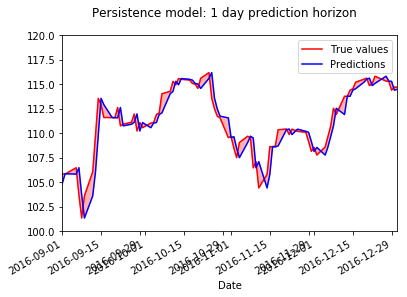

In [77]:
horizon = 1
y_train = train.loc[:, 't+' + str(horizon)].dropna()
y_test = test.loc[:, 't+' + str(horizon)].dropna()    
# make predictions using Persistence model (baseline)
yhat_train = X_train['Adj. Close']
yhat_test = X_test.iloc[:-horizon, 0] # skip rows with no values    
# plot predictions and true values
f, ax = plt.subplots(1)
# stock_ts['Adj. Close'].plot(ax=ax)
y_test.plot(color='red', ax=ax, label="True values")
yhat_test.plot(color='blue', ax=ax, label="Predictions")
ax.fill_between(y_test.index, y_test, yhat_test, 
                color='red', alpha=0.3)
ax.set_xlim("2016-09-01", "2016-12-31")
ax.set_ylim(100, 120)
ax.legend(loc='best')
plt.suptitle("Persistence model: {0} day prediction horizon"
             .format(horizon))
plt.show()

### 10-day horizon of prediction

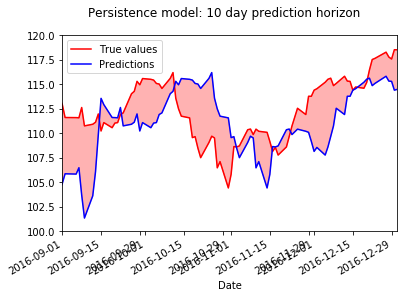

In [78]:
horizon = 10
y_train = train.loc[:, 't+' + str(horizon)].dropna()
y_test = test.loc[:, 't+' + str(horizon)].dropna()    
# make predictions using Persistence model (baseline)
yhat_train = X_train['Adj. Close']
yhat_test = X_test.iloc[:-horizon, 0] # skip rows with no values    
# plot predictions and true values
f, ax = plt.subplots(1)
# stock_ts['Adj. Close'].plot(ax=ax)
y_test.plot(color='red', ax=ax, label="True values")
yhat_test.plot(color='blue', ax=ax, label="Predictions")
ax.fill_between(y_test.index, y_test, yhat_test, 
                color='red', alpha=0.3)
ax.set_xlim("2016-09-01", "2016-12-31")
ax.set_ylim(100, 120)
ax.legend(loc='best')
plt.suptitle("Persistence model: {0} day prediction horizon"
             .format(horizon))
plt.show()

### 1, 5, 10, 20, 80, 240 days horizons

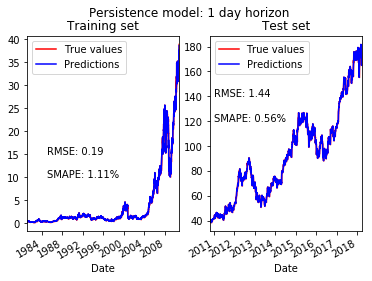

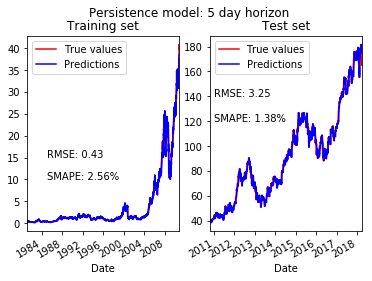

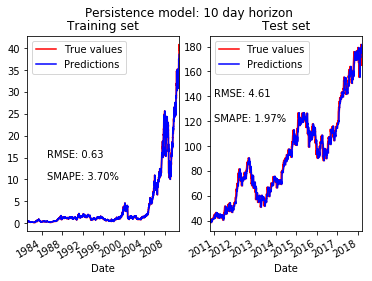

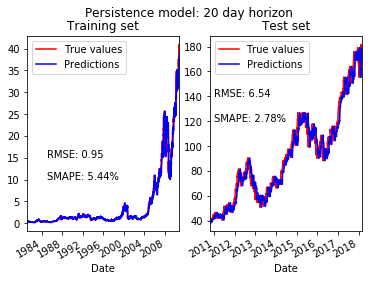

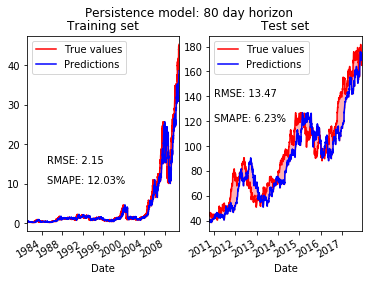

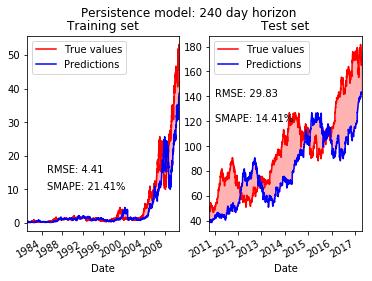

In [81]:
horizons = [1, 5, 10, 20, 80, 240]

for horizon in horizons:
    # select target variable
    y_train = train.loc[:, 't+' + str(horizon)].dropna()
    y_test = test.loc[:, 't+' + str(horizon)].dropna()
    
    # make predictions using Persistence model (baseline)
    yhat_train = X_train['Adj. Close']
    yhat_test = X_test.iloc[:-horizon, 0] # skip rows with no values
    
    # assess model performance
    rmse_train = rmse(y_train, yhat_train)
    smape_train = smape(y_train, yhat_train)
    rmse_test = rmse(y_test, yhat_test)
    smape_test = smape(y_test, yhat_test)
    f, axes = plt.subplots(nrows=1, ncols=2)
    y_train.plot(color='red', ax=axes[0], label="True values")
    yhat_train.plot(color='blue', ax=axes[0], label="Predictions")
    axes[0].fill_between(y_train.index, y_train, yhat_train, 
                    color='red', alpha=0.3)
    axes[0].legend(loc='upper left')
    axes[0].set_title("Training set")    
    axes[0].text("1985", 15, "RMSE: {0:.2f}".format(rmse_train))
    axes[0].text("1985", 10, "SMAPE: {0:.2f}%".format(smape_train))
    # axes[0].text("SMAPE: {0}".format(smape_train))
    y_test.plot(color='red', ax=axes[1], label="True values")
    yhat_test.plot(color='blue', ax=axes[1], label="Predictions")
    axes[1].fill_between(y_test.index, y_test, yhat_test, 
                    color='red', alpha=0.3)
    axes[1].set_title("Test set")
    axes[1].legend(loc='upper left')
    axes[1].text("2011", 140, "RMSE: {0:.2f}".format(rmse_test))
    axes[1].text("2011", 120, "SMAPE: {0:.2f}%".format(smape_test))
    plt.suptitle("Persistence model: {0} day horizon"
                 .format(horizon))
    plt.show()

### Rolling mean

Rolling means (or moving averages) are generally used to smooth out short-term fluctuations in time series data and highlight long-term trends.

In [112]:
windows = [36, 26, 18, 10, 7, 3]
train_subset_ratio = 8 / 10
    
i = 0
for series in ts_list:
    # determine the size of training set    
    train_size_rm = int(len(series) * train_subset_ratio)
    # split the data set into train and test
    y_train, y_test = \
        series.iloc[0:train_size_rm], \
        series.iloc[train_size_rm:len(series)]
    
    # make predictions using rolling mean (baseline)
    yhat_train = y_train.rolling(window=windows[i]).mean()
    yhat_test = y_test.rolling(window=windows[i]).mean()        
    yhat_train = yhat_train.dropna()
    yhat_test = yhat_test.dropna()
    
    # crop values out of the window range
    y_train_crop = y_train[len(y_train) - len(yhat_train):]
    y_test_crop = y_test[len(y_test) - len(yhat_test):]
    
    # assess model performance
    rmse_train = rmse(y_train_crop, yhat_train)
    smape_train = smape(y_train_crop, yhat_train)
    rmse_test = rmse(y_test_crop, yhat_test)
    smape_test = smape(y_test_crop, yhat_test)
    
    # plot model results
    f, axes = plt.subplots(nrows=1, ncols=2)
    y_train.plot(ax=axes[0], color='red',
                 label="True values")
    yhat_train.plot(ax=axes[0], color='blue',
                    label="Predictions")
#    axes[0].fill_between(y_train.index, y_train, yhat_train, 
#                    color='red', alpha=0.3)
    axes[0].legend(loc='best')
    axes[0].set_title("Training set")    
    axes[0].text("1985", 15, "RMSE: {0:.2f}".format(rmse_train))
    axes[0].text("1985", 10, "SMAPE: {0:.2f}%".format(smape_train))
    
    y_test.plot(ax=axes[1], color='red',
                label="True values")
    yhat_test.plot(ax=axes[1], color='blue',
                   label="Predictions")
#    axes[1].fill_between(y_test.index, y_test, yhat_test, 
#                    color='red', alpha=0.3)
    axes[1].text("2011", 140, "RMSE: {0:.2f}".format(rmse_test))
    axes[1].text("2011", 120, "SMAPE: {0:.2f}%".format(smape_test))
    axes[1].legend(loc='best')
    axes[1].set_title("Test set")
    plt.suptitle("Rolling mean (window length {0}) of\n"
                 .format(windows[i]) + ts_title_list[i])
    plt.show()
    
    i += 1

AttributeError: 'NoneType' object has no attribute 'update'

<Figure size 432x288 with 2 Axes>

AttributeError: 'NoneType' object has no attribute 'update'

<Figure size 432x288 with 2 Axes>

AttributeError: 'NoneType' object has no attribute 'update'

<Figure size 432x288 with 2 Axes>

AttributeError: 'NoneType' object has no attribute 'update'

<Figure size 432x288 with 2 Axes>

AttributeError: 'NoneType' object has no attribute 'update'

<Figure size 432x288 with 2 Axes>

AttributeError: 'NoneType' object has no attribute 'update'

<Figure size 432x288 with 2 Axes>

## Linear Models
### Three classes of linear process models encountered in Digital Signal Processing (DSP) theory 

Time series are the **focus of several overlapping disciplines**:

* **Information Theory** deals with describing stochastic time series.

* **Dynamical Systems Theory** deals with describing and manipulating mostly non-linear deterministic time series.

* **Digital Signal Processing (DSP)** deals with describing and manipulating mostly linear time series, both deterministic and stochastic.

**Digital Signal Processing (DSP)** proposes three main classes of linear process models:

* **Autoregressive** ($AR[p]$) models


* **Moving Average** ($MA[q]$) models

$MA[q]$ at its heart is a _Finite Impulse Response (FIR) filter_ (convolution of the input signal $u[t]$ with a given coefficient vector $ \{ \beta_i \})$ applied to some (unknown) internal signal, $\epsilon[t]$. $q + 1$ is the order of that filter.

$$ \large{ x[t] ~ = ~ \sum_{i=0}^q \beta_i \epsilon [t-i] } $$

In this case, we cannot assume that $\epsilon [t]$ is negligible; $x[t]$ would have to be negligible. This method is seldom used alone in practice, as by using the equation above, we are not making explicit use of the past values of $x[t]$.

A diagram of an _Finite Impulse Response (FIR) Filter_:

<img src='img/pic_4.png' width='300'>

* **Autoregressive Moving Average** ($ARMA[p, q]$) models

A combination of the $AR[p]$ and $MA[q]$ models:

$$ \large{ x[t] ~ = ~ \sum_{i=1}^p \alpha_i x [t-i] ~ + ~ \sum_{i=1}^q \beta_i \epsilon [t-i] + \epsilon[t] } $$

To estimate values of $x[t]$, we assume that $\epsilon[t]$ at time $t$ is small relative to $x[t]$. We can obtain estimates of past values of $\epsilon[t]$ at time $t-i$ from past true values of $x[t]$ and past values of $\hat{x}[t]$:

$$ \large{ \hat{\epsilon}[t-i] ~ = ~ x[t-i] ~ - ~ \hat{x}[t-i] } $$

The estimate for $x[t]$ is then 

$$ \large{ \hat{x}[t] = \sum_{i=1}^p \alpha_i x [t-i] ~ + ~ \sum_{i=1}^q \beta_i \hat{\epsilon} [t-i] } $$

### Autoregression (AR)
An autoregression model is a linear regression model that uses lagged variables as input variables.

$AR[p]$ at its heart is an _Infinite Impulse Response (IIR) filter_ (input $u[t]$ contributes to $x[t]$ at time $t$, but otherwise $x[t]$ _is a weighted sum of its own past samples_ given a coefficient vector $\alpha_i$) applied to some (unknown) internal signal, $\epsilon[t]$. $p$ is the order of that filter. 

$$ \large{ x[t] = \sum_{i=1}^p a_i x[t-i] ~ + ~ \epsilon[t] } $$

if on average $\epsilon[t]$ is small compared to $x[t]$, then we can estimate $\hat{x}[t]$ using

$$ \large{ \hat{x} ~ \equiv ~ x[t] ~ - ~ \epsilon [t] = \sum_{i=1}^p w_i x [t-i] } $$ 

The $w_i$'s are estimates of $\alpha_i$'s.

A diagram of an _Infinite Impulse Response (IRR) filter_:

<img src='img/pic_3.png' width='300'>

The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps. The notation for the model involves specifying the order of the model p as a parameter to the AR function, e.g. AR[p]. For example, AR[1] is a first-order autoregression model. The method is **suitable for univariate time series without trend and seasonal components**.

We could calculate the linear regression model manually using the `LinearRegression` class in `scikit-learn` and manually specify the lag input variables to use. Alternately, the `statsmodels` library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the `AR class`.
### 1-day horizon of prediction

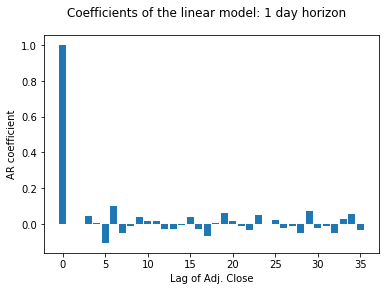

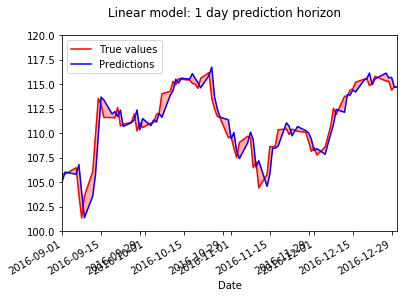

In [82]:
from sklearn.linear_model import LinearRegression

# select the target variable
horizon = 1
y_train = train.loc[:, 't+' + str(horizon)].dropna()
y_test = test.loc[:, 't+' + str(horizon)].dropna()

# train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# use trained model to make predictions
yhat_train = pd.Series(model.predict(X_train), index=X_train.index)
yhat_test = pd.Series(model.predict(X_test), index=X_test.index)

# plot model coefficients
plt.bar(np.arange(len(X_train.columns)), model.coef_)
plt.xticks(np.arange(0, len(X_train.columns), 5))
plt.xlabel("Lag of {0}".format(column))
plt.ylabel("AR coefficient")
plt.suptitle("Coefficients of the linear model: {0} day horizon"
             .format(horizon))
plt.show()

# plot predictions and true values
f, ax = plt.subplots(1)
# stock_ts['Adj. Close'].plot(ax=ax)
y_test.plot(color='red', ax=ax, label="True values")
yhat_test.plot(color='blue', ax=ax, label="Predictions")
ax.fill_between(y_test.index, y_test, yhat_test[:-horizon], 
                color='red', alpha=0.3)
ax.set_xlim("2016-09-01", "2016-12-31")
ax.set_ylim(100, 120)
ax.legend(loc='best')
plt.suptitle("Linear model: {0} day prediction horizon"
             .format(horizon))
plt.show()

### 10-day horizon of prediction

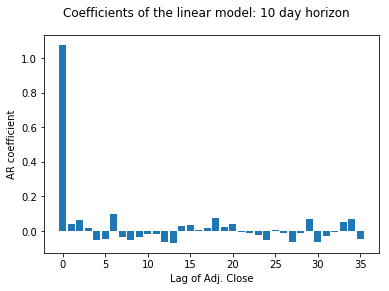

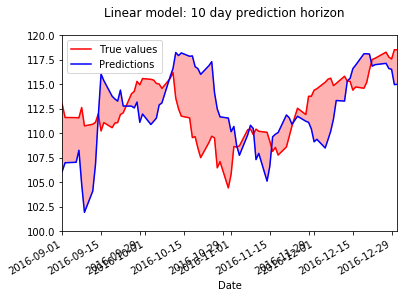

In [83]:
# select the target variable
horizon = 10
y_train = train.loc[:, 't+' + str(horizon)].dropna()
y_test = test.loc[:, 't+' + str(horizon)].dropna()

# train a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# use trained model to make predictions
yhat_train = pd.Series(model.predict(X_train), index=X_train.index)
yhat_test = pd.Series(model.predict(X_test), index=X_test.index)

# plot model coefficients
plt.bar(np.arange(len(X_train.columns)), model.coef_)
plt.xticks(np.arange(0, len(X_train.columns), 5))
plt.xlabel("Lag of {0}".format(column))
plt.ylabel("AR coefficient")
plt.suptitle("Coefficients of the linear model: {0} day horizon"
             .format(horizon))
plt.show()

# plot predictions and true values
f, ax = plt.subplots(1)
# stock_ts['Adj. Close'].plot(ax=ax)
y_test.plot(color='red', ax=ax, label="True values")
yhat_test.plot(color='blue', ax=ax, label="Predictions")
ax.fill_between(y_test.index, y_test, yhat_test[:-horizon], 
                color='red', alpha=0.3)
ax.set_xlim("2016-09-01", "2016-12-31")
ax.set_ylim(100, 120)
ax.legend(loc='best')
plt.suptitle("Linear model: {0} day prediction horizon"
             .format(horizon))
plt.show()

### 1, 5, 10, 20, 80, 240 days horizons

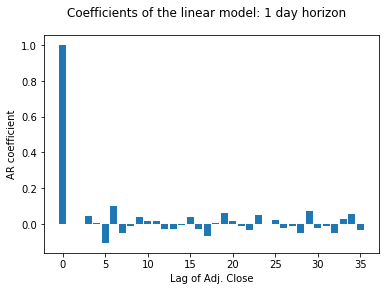

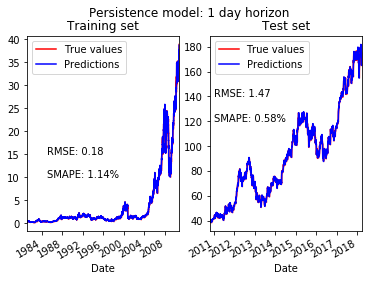

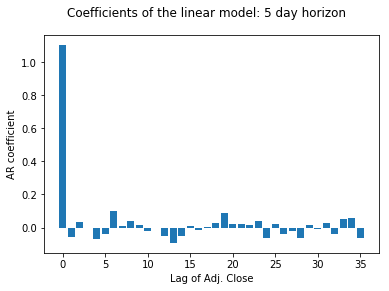

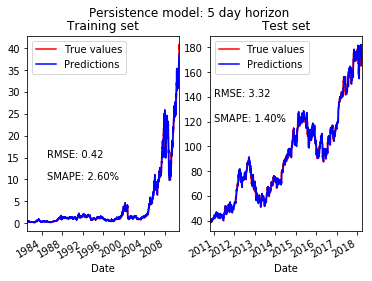

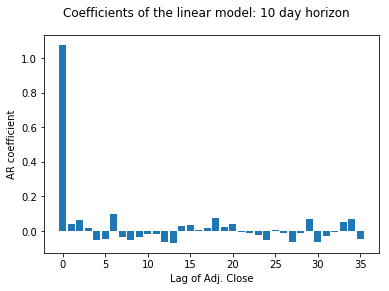

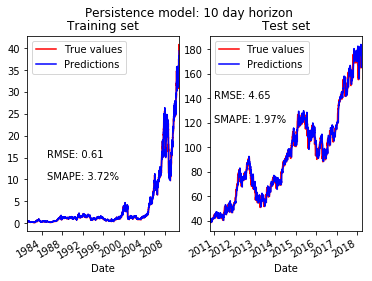

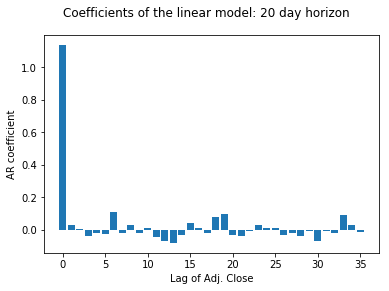

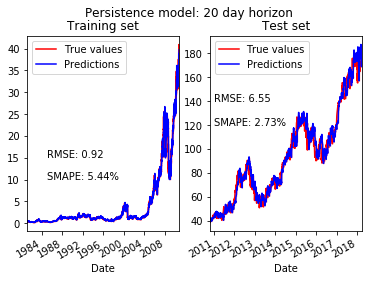

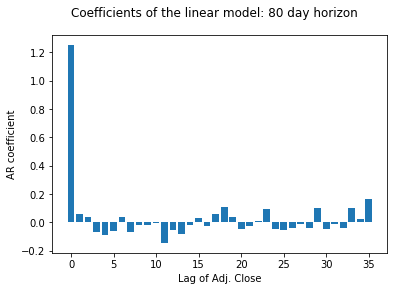

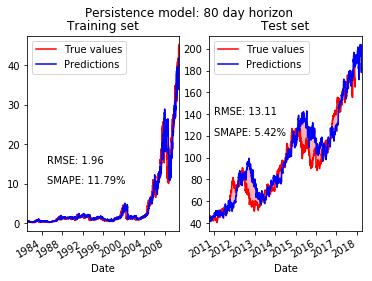

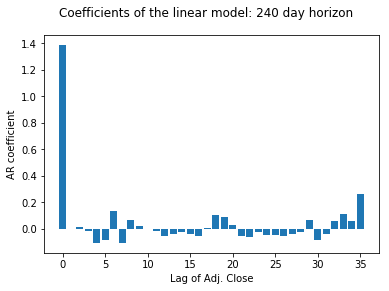

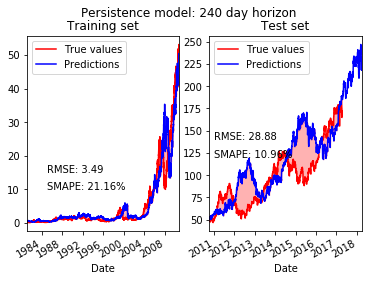

In [84]:
horizons = [1, 5, 10, 20, 80, 240]

for horizon in horizons:
    # select target variable
    y_train = train.loc[:, 't+' + str(horizon)].dropna()
    y_test = test.loc[:, 't+' + str(horizon)].dropna()
    
    # train a Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # use trained model to make predictions
    yhat_train = pd.Series(model.predict(X_train), index=X_train.index)
    yhat_test = pd.Series(model.predict(X_test), index=X_test.index)

    # assess model performance
    score_train = rmse(y_train, yhat_train)
    smape_train = smape(y_train, yhat_train)
    score_test = rmse(y_test, yhat_test[:-horizon])
    smape_test = smape(y_test, yhat_test[:-horizon])
    
    # plot model coefficients
    plt.bar(np.arange(len(X_train.columns)), model.coef_)
    plt.xticks(np.arange(0, len(X_train.columns), 5))
    plt.xlabel("Lag of {0}".format(column))
    plt.ylabel("AR coefficient")
    plt.suptitle("Coefficients of the linear model: {0} day horizon"
                 .format(horizon))
    plt.show()
    
    f, axes = plt.subplots(nrows=1, ncols=2)
    y_train.plot(color='red', ax=axes[0], label="True values")
    yhat_train.plot(color='blue', ax=axes[0], label="Predictions")
    axes[0].fill_between(y_train.index, y_train, yhat_train, 
                    color='red', alpha=0.3)
    axes[0].legend(loc='upper left')
    axes[0].set_title("Training set")    
    axes[0].text("1985", 15, "RMSE: {0:.2f}".format(score_train))
    axes[0].text("1985", 10, "SMAPE: {0:.2f}%".format(smape_train))
    # axes[0].text("SMAPE: {0}".format(smape_train))
    y_test.plot(color='red', ax=axes[1], label="True values")
    yhat_test.plot(color='blue', ax=axes[1], label="Predictions")
    axes[1].fill_between(y_test.index, y_test, yhat_test[:-horizon], 
                    color='red', alpha=0.3)
    axes[1].set_title("Test set")
    axes[1].legend(loc='upper left')
    axes[1].text("2011", 140, "RMSE: {0:.2f}".format(score_test))
    axes[1].text("2011", 120, "SMAPE: {0:.2f}%".format(smape_test))
    plt.suptitle("Persistence model: {0} day horizon"
                 .format(horizon))
    plt.show()

### Autoregression AR[p] model from `statsmodels`

In [85]:
from statsmodels.tsa.ar_model import AR

# fit AR model on input series
model = AR(stock_ts_se)
fit_ar = model.fit()

window = fit_ar.k_ar
coef = fit_ar.params
w = coef[1:]
b = coef[0]

In [93]:
w

L1.Adj. Close     1.029555
L2.Adj. Close    -0.059399
L3.Adj. Close     0.013625
L4.Adj. Close     0.069112
L5.Adj. Close    -0.075287
L6.Adj. Close     0.011125
L7.Adj. Close     0.050815
L8.Adj. Close    -0.076799
L9.Adj. Close     0.061829
L10.Adj. Close   -0.021130
L11.Adj. Close   -0.030208
L12.Adj. Close    0.003790
L13.Adj. Close    0.025323
L14.Adj. Close    0.035274
L15.Adj. Close   -0.059875
L16.Adj. Close    0.027772
L17.Adj. Close    0.006372
L18.Adj. Close   -0.008892
L19.Adj. Close   -0.012658
L20.Adj. Close    0.042854
L21.Adj. Close   -0.034860
L22.Adj. Close   -0.054012
L23.Adj. Close    0.033328
L24.Adj. Close    0.032661
L25.Adj. Close   -0.056643
L26.Adj. Close    0.095171
L27.Adj. Close   -0.067175
L28.Adj. Close    0.002257
L29.Adj. Close    0.035473
L30.Adj. Close   -0.030447
L31.Adj. Close    0.008286
L32.Adj. Close    0.015098
L33.Adj. Close   -0.001730
L34.Adj. Close   -0.014980
L35.Adj. Close   -0.051240
L36.Adj. Close    0.037667
L37.Adj. Close    0.018646
d

In [86]:
b

0.00509760828681715

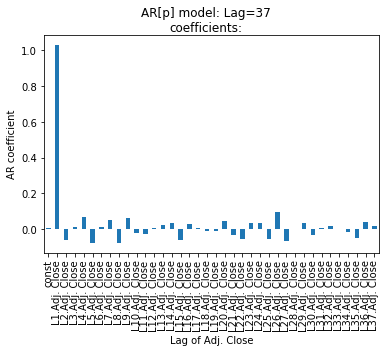

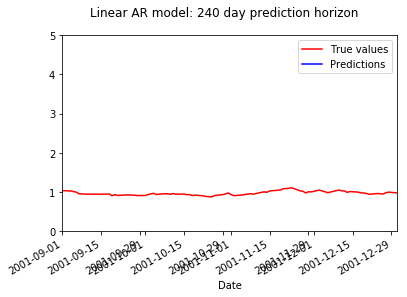

In [92]:
# use trained model to make predictions
yhat_train = pd.Series(fit_ar.predict(len(X_train.columns) + 1,
                                      len(X_train)), 
                       index=X_train.index)
yhat_test = pd.Series(fit_ar.predict(len(X_test.columns) + 1,
                                     len(X_test)), 
                      index=X_test.index)

# plot model coefficients
fit_ar.params.plot(kind='bar')
plt.xlabel("Lag of {0}".format(column))
plt.ylabel("AR coefficient")
plt.suptitle("AR[p] model: Lag={0}\ncoefficients:"
             .format(fit_ar.k_ar));
plt.show()

# plot predictions and true values
f, ax = plt.subplots(1)
# stock_ts['Adj. Close'].plot(ax=ax)
y_train.plot(color='red', ax=ax, label="True values")
yhat_train.plot(color='blue', ax=ax, label="Predictions")
ax.fill_between(y_train.index, y_train, yhat_train, 
                color='red', alpha=0.3)
ax.set_xlim("2001-09-01", "2001-12-31")
ax.set_ylim(0, 5)
ax.legend(loc='best')
plt.suptitle("Linear AR model: {0} day prediction horizon"
             .format(horizon))
plt.show()

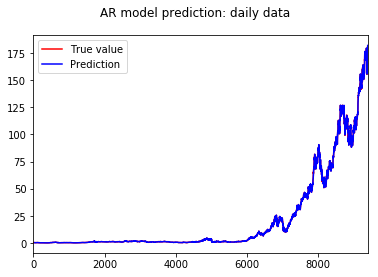

In [95]:
# AR example
from statsmodels.tsa.ar_model import AR
# fit model (daily data)
model = AR(X_se)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(40, len(X_se))
X_se.plot(color='red', label="True value")
yhat.plot(color='blue', label="Prediction")
plt.suptitle("AR model prediction: daily data")
plt.legend(loc='upper left')

Text(0.5, 0.98, 'AR model prediction: monthly data')

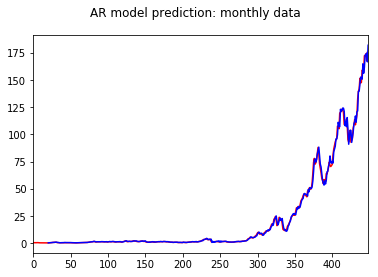

In [98]:
# fit model(monthly data)
model = AR(X_m_se)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(20, len(X_m_se))
X_m_se.plot(color='red', label="True value")
yhat.plot(color='blue', label="Prediction")
plt.suptitle("AR model prediction: monthly data")

Text(0.5, 0.98, 'AR model prediction: monthly data')

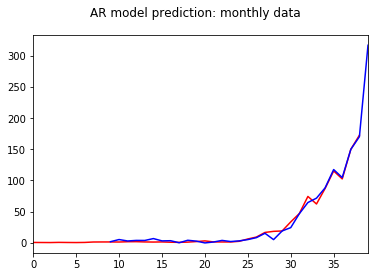

In [104]:
# fit model(monthly data)
model = AR(X_y_se)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(9, len(X_y_se))
X_y_se.plot(color='red', label="True value")
yhat.plot(color='blue', label="Prediction")
plt.suptitle("AR model prediction: monthly data")
